# CNN Model dla prognozowania cen akcji

Ten notebook implementuje model CNN (1D Convolutional Neural Network) oparty na pliku `cnn_model.py`, który analizuje dane giełdowe identycznie jak LSTM.

## 1. Import bibliotek

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Dodanie katalogu głównego do ścieżki
sys.path.append('..')

from src.cnn_model import TimeSeriesCNN, CNNTrainer, prepare_data_for_cnn
from src.utils import (
    create_directories,
    plot_training_history,
    plot_predictions,
    evaluate_model,
    print_metrics,
    save_model
)

# Styl wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
sns.set_context('talk')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Używane urządzenie: {device}')

create_directories()

Używane urządzenie: cpu
Struktura katalogów utworzona pomyślnie.


## 2. Wczytanie danych

In [3]:
data_path = "../data/processed/cleaned_data.csv"

# Jeśli dane nie istnieją, wykonaj preprocessing
if not os.path.exists(data_path):
    from src.data_preprocessing import preprocess
    df = preprocess()
else:
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])

print(f"Liczba wierszy w danych: {len(df)}")
df.head()

Liczba wierszy w danych: 250


,Date,Close/Last,Volume,Open,High,Low
0,2024-05-28,176.75,59736620,176.400,178.2500,173.16
1,2024-05-29,176.19,54782650,174.190,178.1500,173.93
2,2024-05-30,178.79,77784760,178.575,182.6700,175.38
3,2024-05-31,178.08,67314600,178.500,180.3200,173.82
4,2024-06-03,176.29,68568920,178.130,182.6389,174.49


## 3. Przygotowanie danych

In [4]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
target_col = 'Close/Last'
seq_length = 20

data = prepare_data_for_cnn(
    df=df,
    feature_cols=feature_cols,
    target_col=target_col,
    seq_length=seq_length,
    test_size=0.2,
    val_size=0.1,
    batch_size=32,
    shuffle=True
)

print(f"Liczba próbek treningowych: {len(data['X_train'])}")
print(f"Liczba próbek walidacyjnych: {len(data['X_val'])}")
print(f"Liczba próbek testowych: {len(data['X_test'])}")
print(f"Rozmiar danych wejściowych: {data['X_train'].shape}")

Liczba próbek treningowych: 161
Liczba próbek walidacyjnych: 23
Liczba próbek testowych: 46
Rozmiar danych wejściowych: (161, 20, 4)


## 4. Budowa i trening modelu CNN

In [5]:
model = TimeSeriesCNN(
    input_channels=data['input_channels'],
    seq_length=data['seq_length']
)

trainer = CNNTrainer(model)

history = trainer.fit(
    train_loader=data['train_loader'],
    val_loader=data['val_loader'],
    epochs=50,
    early_stopping_patience=7
)

Epoka 1/50, Strata treningowa: 0.167723, Strata walidacyjna: 0.159471
Epoka 2/50, Strata treningowa: 0.067425, Strata walidacyjna: 0.122865
Epoka 3/50, Strata treningowa: 0.059313, Strata walidacyjna: 0.111029
Epoka 4/50, Strata treningowa: 0.039747, Strata walidacyjna: 0.099875
Epoka 5/50, Strata treningowa: 0.047902, Strata walidacyjna: 0.090895
Epoka 6/50, Strata treningowa: 0.043858, Strata walidacyjna: 0.061809
Epoka 7/50, Strata treningowa: 0.060348, Strata walidacyjna: 0.050952
Epoka 8/50, Strata treningowa: 0.032265, Strata walidacyjna: 0.030219
Epoka 9/50, Strata treningowa: 0.061596, Strata walidacyjna: 0.007533
Epoka 10/50, Strata treningowa: 0.045582, Strata walidacyjna: 0.007477
Epoka 11/50, Strata treningowa: 0.037372, Strata walidacyjna: 0.022015
Epoka 12/50, Strata treningowa: 0.071734, Strata walidacyjna: 0.011548
Epoka 13/50, Strata treningowa: 0.028775, Strata walidacyjna: 0.004453
Epoka 14/50, Strata treningowa: 0.037718, Strata walidacyjna: 0.012827
Epoka 15/50, St

## 5. Predykcja i wizualizacja wyników

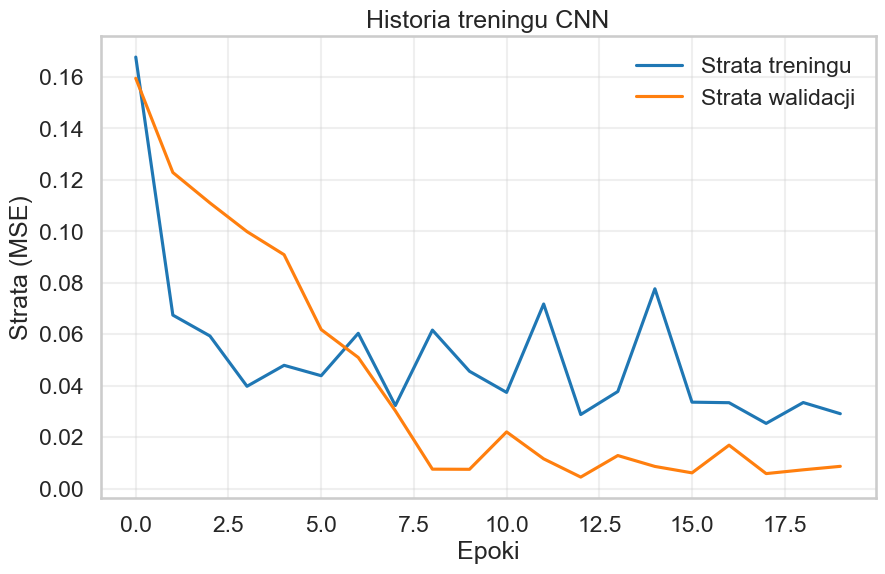

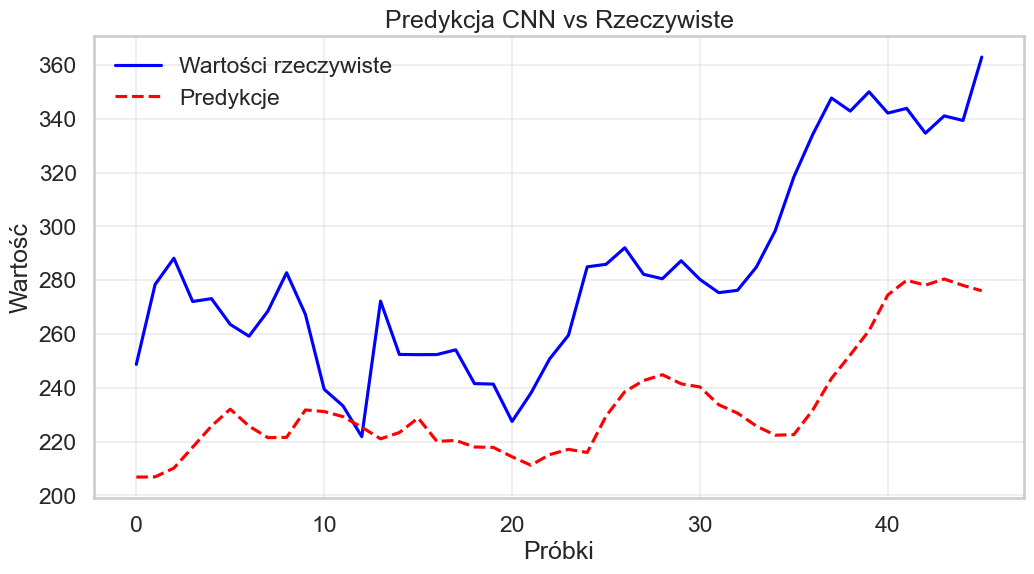

In [8]:
from IPython.display import display

fig1 = plot_training_history(history, title="Historia treningu CNN")
display(fig1)

fig2 = plot_predictions(data['y_test'], y_pred, scaler=data['target_scaler'], title="Predykcja CNN vs Rzeczywiste")
display(fig2)


## 6. Ewaluacja modelu

In [9]:
metrics = evaluate_model(data['y_test'], y_pred, scaler=data['target_scaler'])
print_metrics(metrics)


=== Metryki wydajności modelu ===
MSE: 3099.480849
RMSE: 55.672981
MAE: 49.828216
R²: -1.219826
